# Importing the packages and data

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import scipy
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from scipy.special import gamma, digamma, polygamma
import math

from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import random

import scipy.optimize
from scipy.stats import ttest_ind
from scipy.optimize import Bounds

from prettytable import PrettyTable

In [3]:
import sys
sys.path.append("../smote_cd/")
from smote_cd.dataset_generation import softmax

In [4]:
import dirichlet_regression

In [5]:
from scipy.optimize import fmin, newton, minimize

In [6]:
def f_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, Minv=Minv)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [7]:
def fprime_spatial(x, X, Y, Z, W, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    n = X.shape[0]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:-1]
    rho = x[-1]
    Minv = np.linalg.inv(np.identity(n) - rho*W)
    MinvX = np.matmul(Minv,X)
    mu = dirichlet_regression.compute_mu_spatial_2(X, beta, rho=rho, W=W, MinvX=MinvX)
    phi = np.exp(np.matmul(Z,gamma_var))

    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, MinvX, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, MinvX, Y, Z, epsilon=epsilon)
    rho_derivative = dirichlet_regression.dirichlet_derivative_wrt_rho(mu, phi, Minv, beta, W, X, Y, Z, MinvX, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad,[rho_derivative]]))

In [8]:
def f_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    return -dirichlet_regression.dirichlet_loglikelihood(mu,phi,Y,epsilon=epsilon)

In [9]:
def fprime_no_spatial(x, X, Y, Z, epsilon=0):
    K = X.shape[-1]
    J = Y.shape[-1]
    beta = x[:K*J].reshape((K,J))
    beta[:,0] = 0
    gamma_var = x[K*J:]
    mu = dirichlet_regression.compute_mu_3(X, beta)
    phi = np.exp(np.matmul(Z,gamma_var))
    beta_grad = dirichlet_regression.dirichlet_gradient_wrt_beta(mu, phi, X, Y, epsilon=epsilon)
    beta_grad[:,0] = 0
    gamma_grad = dirichlet_regression.dirichlet_derivative_wrt_gamma(mu, phi, beta, X, Y, Z, epsilon=epsilon)
    return(-np.concatenate([beta_grad.flatten(),gamma_grad]))

In [77]:
# sur mon ordi perso:
scipy.__version__

'1.4.1'

In [3]:
# sur ordi MQ:
scipy.__version__

'1.4.1'

# Loading Arctic Lake

In [10]:
arctic = pd.read_csv('Data Dirichlet/ArcticLake.csv')

In [11]:
Y_arctic = arctic.iloc[:,:3]
X_arctic = arctic.iloc[:,3]

In [12]:
Y_arctic = np.array(Y_arctic)

In [13]:
X_arctic = np.array([[j] for j in X_arctic])

In [14]:
Z_arctic = np.ones(len(X_arctic)).reshape((39,1))

In [15]:
n_features = 1
n_classes = 3

In [16]:
neighbors = NearestNeighbors(n_neighbors=35).fit(X_arctic)
#W_arctic = neighbors.kneighbors_graph(X_arctic).toarray()
# replace the 1 on the diagonal by 0
#np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
#W_arctic = W_arctic/5

# OR THE WEIGHTED GRAPH :
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

### With an intercept

In [17]:
neighbors = NearestNeighbors(n_neighbors=29).fit(X_arctic)
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [18]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [19]:
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

In [20]:
beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]
rho0 = [0.]

params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [21]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds = Bounds(min_bounds_1, max_bounds_1)

In [94]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), 
                              jac=fprime_spatial, bounds=bounds)

Wall time: 219 ms


In [95]:
beta_arctic_1_dist = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_arctic_1_dist = solution_arctic_bis.x[-1]

mu_arctic_1_dist = dirichlet_regression.compute_mu_spatial_2(X_arctic_1_bis, beta_arctic_1_dist, rho_arctic_1_dist, W_arctic)

gamma_var_arctic_1_dist = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
phi_arctic_1_dist = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1_dist))

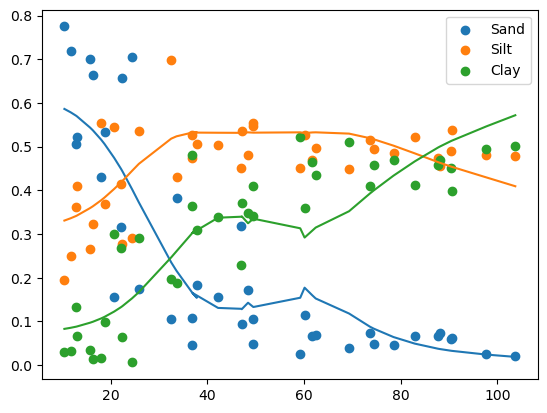

In [96]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_1_dist)
plt.legend()
plt.show()

In [98]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_1_dist))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_1_dist,squared=False))
print('AIC :',2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1_dist,phi_arctic_1_dist,Y_arctic))

Scores between Y and mu
R2 : 0.6191313092696689
RMSE : 0.09651610168967188
AIC : -151.63958804526004


In [369]:
list_r2_1 = []
list_rmse_1 = []
list_aic_1 = []
for nn in range(5,38):
    neighbors = NearestNeighbors(n_neighbors=nn).fit(X_arctic)
    W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), 
                              jac=fprime_spatial, bounds=bounds)
    
    beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
    rho_arctic_1 = solution_arctic_bis.x[-1]

    mu_arctic_1 = dirichlet_regression.compute_mu_spatial_3(X_arctic_1_bis, beta_arctic_1, rho_arctic_1, W_arctic)

    gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
    phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))
    
    list_r2_1.append(r2_score(Y_arctic,mu_arctic_1))
    list_rmse_1.append(mean_squared_error(Y_arctic,mu_arctic_1,squared=False))
    list_aic_1.append(2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1,phi_arctic_1,Y_arctic))

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:105: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:119: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:268: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(M

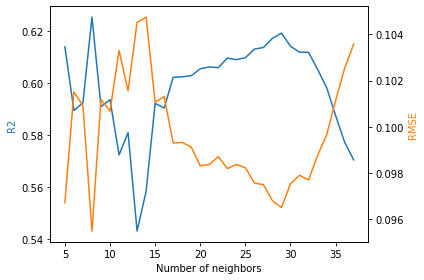

In [380]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('R2', color=color)
ax1.plot(np.arange(5,38),list_r2_1,label='R2',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(np.arange(5,38),list_rmse_1,label='RMSE',color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

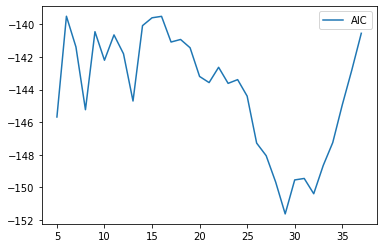

In [382]:
plt.plot(np.arange(5,38),np.array(list_aic_1),label='AIC')
plt.legend()
plt.show()

### With X^2

In [22]:
neighbors = NearestNeighbors(n_neighbors=5).fit(X_arctic)
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [23]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [24]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [25]:
beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [26]:
min_bounds_2 = -np.inf*np.ones(len(params0)) 
max_bounds_2 = np.inf*np.ones(len(params0))
min_bounds_2[-1] = -1
max_bounds_2[-1] = 1
bounds_2 = Bounds(min_bounds_2, max_bounds_2)

In [142]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic), 
                             jac=fprime_spatial, bounds=bounds_2)

Wall time: 722 ms


In [143]:
beta_arctic_2_dist = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_arctic_2_dist = solution_arctic_bis.x[-1]

mu_arctic_2_dist = dirichlet_regression.compute_mu_spatial_3(X_arctic_2_bis, beta_arctic_2_dist, rho_arctic_2_dist, W_arctic)

gamma_var_arctic_2_dist = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
phi_arctic_2_dist = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2_dist))

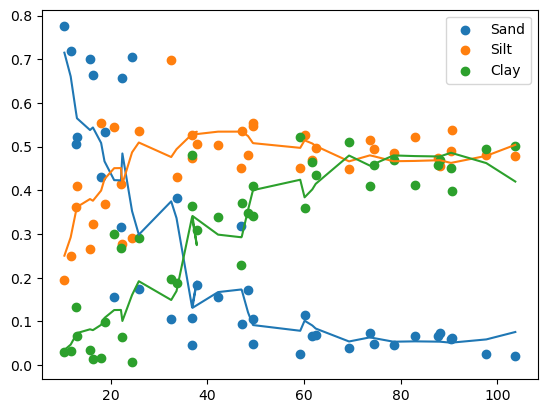

In [144]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_2_dist)
plt.legend()
plt.show()

In [145]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_2_dist))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_2_dist,squared=False))
print('AIC :',2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_dist,phi_arctic_2_dist,Y_arctic))

Scores between Y and mu
R2 : 0.7068615286545515
RMSE : 0.08223781723539907
AIC : -169.64638096997982


In [410]:
list_r2_2 = []
list_rmse_2 = []
list_aic_2 = []
for nn in range(5,38):
    neighbors = NearestNeighbors(n_neighbors=nn).fit(X_arctic)
    W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic), 
                              jac=fprime_spatial, bounds=bounds_2)
    
    beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
    rho_arctic_2 = solution_arctic_bis.x[-1]

    mu_arctic_2 = dirichlet_regression.compute_mu_spatial_2(X_arctic_2_bis, beta_arctic_2, rho_arctic_2, W_arctic)

    gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
    phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))
    
    list_r2_2.append(r2_score(Y_arctic,mu_arctic_2))
    list_rmse_2.append(mean_squared_error(Y_arctic,mu_arctic_2,squared=False))
    list_aic_2.append(2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic))

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:105: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:119: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:268: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(M

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:105: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:119: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:268: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )


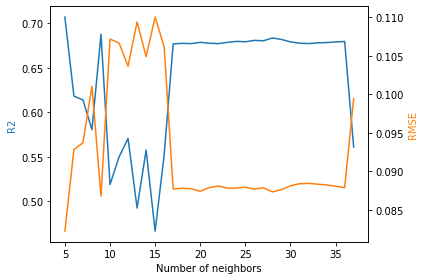

In [421]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('R2', color=color)
ax1.plot(np.arange(5,38),list_r2_2,label='R2',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(np.arange(5,38),list_rmse_2,label='RMSE',color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

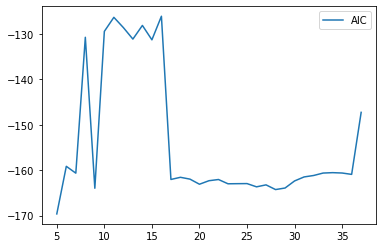

In [422]:
plt.plot(np.arange(5,38),np.array(list_aic_2),label='AIC')
plt.legend()
plt.show()

## W as contiguity-based

All points that are at less than 10m are considered neighbors 

### With an intercept

In [115]:
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
W_arctic = np.zeros(np.shape(distance_matrix))
W_arctic[distance_matrix < 28] = 1
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [116]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

In [117]:
beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]
rho0 = [0.]

params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [118]:
min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds = Bounds(min_bounds_1, max_bounds_1)

In [119]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), 
                              jac=fprime_spatial, bounds=bounds)

Wall time: 271 ms


In [120]:
solution_arctic_bis.message

'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'

In [121]:
beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
rho_arctic_1 = solution_arctic_bis.x[-1]

In [122]:
mu_arctic_1 = dirichlet_regression.compute_mu_spatial_2(X_arctic_1_bis, beta_arctic_1, rho_arctic_1, W_arctic)

gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))

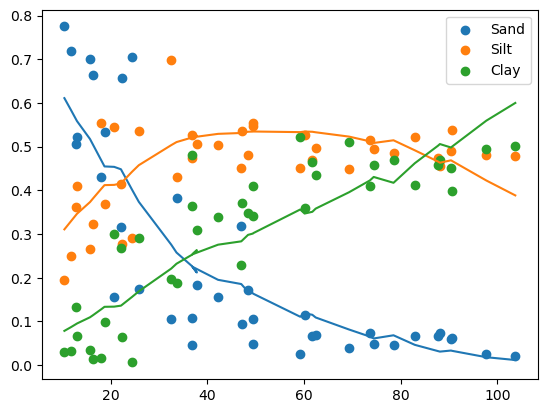

In [123]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_1)
plt.legend()
plt.show()

In [124]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_1))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_1,squared=False))
print('AIC :',2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1,phi_arctic_1,Y_arctic))

Scores between Y and mu
R2 : 0.6324491441317838
RMSE : 0.09513427697341388
AIC : -149.61519265525826


In [48]:
list_r2_1 = []
list_rmse_1 = []
list_aic_1 = []
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
for dist in range(8,100,2):
    W_arctic = np.zeros(np.shape(distance_matrix))
    W_arctic[distance_matrix < dist] = 1
    np.fill_diagonal(W_arctic,0)
    
    W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_1_bis, Y_arctic, Z_arctic, W_arctic), 
                              jac=fprime_spatial, bounds=bounds)
    
    beta_arctic_1 = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
    rho_arctic_1 = solution_arctic_bis.x[-1]

    mu_arctic_1 = dirichlet_regression.compute_mu_spatial_3(X_arctic_1_bis, beta_arctic_1, rho_arctic_1, W_arctic)

    gamma_var_arctic_1 = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
    phi_arctic_1 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1))
    
    list_r2_1.append(r2_score(Y_arctic,mu_arctic_1))
    list_rmse_1.append(mean_squared_error(Y_arctic,mu_arctic_1,squared=False))
    list_aic_1.append(2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1,phi_arctic_1,Y_arctic))

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-M

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-MXbeta[i,j]))
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  mu[i,j] = 1/np.sum(np.exp(MXbeta[i]-M

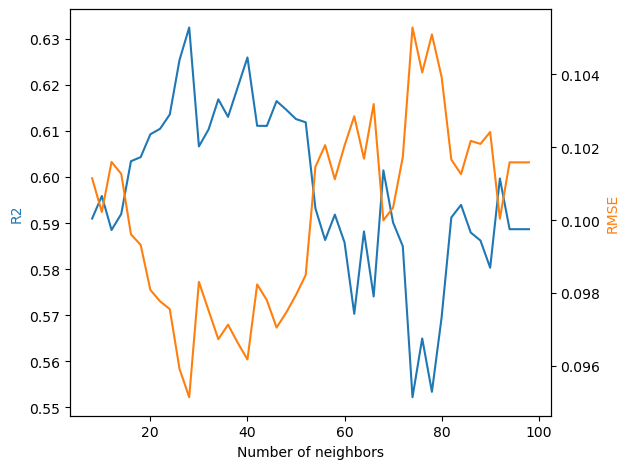

In [49]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('R2', color=color)
ax1.plot(np.arange(8,100,2),list_r2_1,label='R2',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(np.arange(8,100,2),list_rmse_1,label='RMSE',color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

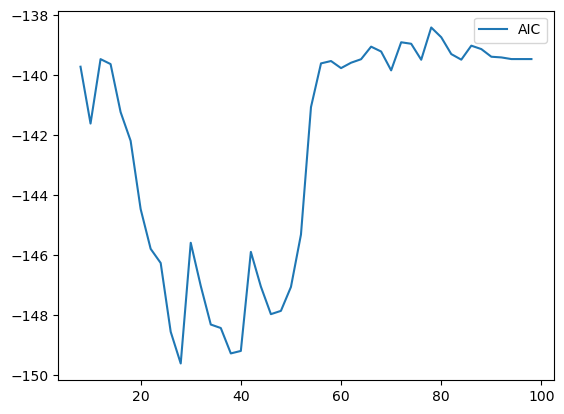

In [50]:
plt.plot(np.arange(8,100,2),np.array(list_aic_1),label='AIC')
plt.legend()
plt.show()

In [51]:
np.min(list_rmse_1) == list_rmse_1[10]

True

In [52]:
np.min(list_aic_1) == list_aic_1[10]

True

### With X^2

In [146]:
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
W_arctic = np.zeros(np.shape(distance_matrix))
W_arctic[distance_matrix < 26] = 1
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [147]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [148]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [149]:
beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

In [150]:
min_bounds_2 = -np.inf*np.ones(len(params0)) 
max_bounds_2 = np.inf*np.ones(len(params0))
min_bounds_2[-1] = -1
max_bounds_2[-1] = 1
bounds_2 = Bounds(min_bounds_2, max_bounds_2)

In [151]:
%%time
solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic), 
                             jac=fprime_spatial, bounds=bounds_2)

Wall time: 419 ms


In [152]:
beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
rho_arctic_2 = solution_arctic_bis.x[-1]

In [153]:
mu_arctic_2 = dirichlet_regression.compute_mu_spatial_2(X_arctic_2_bis, beta_arctic_2, rho_arctic_2, W_arctic)

gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

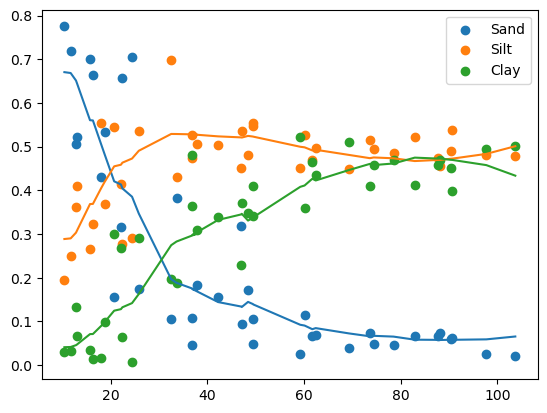

In [154]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_2)
plt.legend()
plt.show()

In [155]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_2))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_2,squared=False))
print('AIC :',2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic))

Scores between Y and mu
R2 : 0.6863036171131137
RMSE : 0.08656455039489412
AIC : -165.52721153752876


In [535]:
list_r2_2 = []
list_rmse_2 = []
list_aic_2 = []
list_distances = []
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
for dist in range(8,100,2):
    print(dist)
    try:
        W_arctic = np.zeros(np.shape(distance_matrix))
        W_arctic[distance_matrix < dist] = 1
        np.fill_diagonal(W_arctic,0)
        W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]
        solution_arctic_bis=minimize(f_spatial, params0, args=(X_arctic_2_bis, Y_arctic, Z_arctic, W_arctic), 
                                  jac=fprime_spatial, bounds=bounds_2)

        beta_arctic_2 = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
        rho_arctic_2 = solution_arctic_bis.x[-1]

        mu_arctic_2 = dirichlet_regression.compute_mu_spatial_2(X_arctic_2_bis, beta_arctic_2, rho_arctic_2, W_arctic)

        gamma_var_arctic_2 = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
        phi_arctic_2 = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2))

        list_distances.append(dist)
        list_r2_2.append(r2_score(Y_arctic,mu_arctic_2))
        list_rmse_2.append(mean_squared_error(Y_arctic,mu_arctic_2,squared=False))
        list_aic_2.append(2*len(solution_arctic_bis.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2,phi_arctic_2,Y_arctic))
    except:
        print('Singular Matrix')

8
10
12
14


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


16


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


18


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


20
22
24


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


26
28
30
32
34
36
38
40
42


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


44
46
48
50
52
54
56


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encounte

58
60


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)


62
64

C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)



66


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encounte

68
70


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encounte

72
74


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


76


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


78


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax


80


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax


82


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value enc

84
86


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


88


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


90


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


92


C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:79: RuntimeWarning: overflow encountered in exp
  # compute the softmax
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:123: RuntimeWarning: invalid value encountered in multiply
  return(derivative_gamma)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:137: RuntimeWarning: invalid value encountered in multiply
  return(hessian)
C:\Users\tnguyen001\Documents\GitHub\maupiti\dirichlet_regression.py:286: RuntimeWarning: invalid value encountered in multiply
  alpha = np.copy(mu)


94
96
98


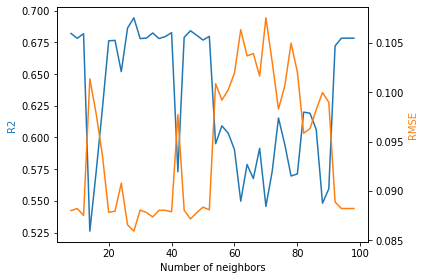

In [536]:
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('Number of neighbors')
ax1.set_ylabel('R2', color=color)
ax1.plot(list_distances,list_r2_2,label='R2',color=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:orange'
ax2.set_ylabel('RMSE', color=color)
ax2.plot(list_distances,list_rmse_2,label='RMSE',color=color)
#ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.show()

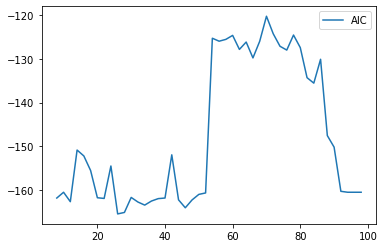

In [537]:
plt.plot(list_distances,np.array(list_aic_2),label='AIC')
plt.legend()
plt.show()

In [538]:
list_distances[np.argmin(list_aic_2)]

26

In [539]:
np.min(list_aic_2)

-165.52721153752896

## Without spatial

In [63]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]

In [64]:
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

In [65]:
beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]

params0_ns = np.concatenate([beta0.flatten(),gamma0])

In [66]:
%%time
solution_arctic=minimize(f_no_spatial, params0_ns, args=(X_arctic_1_bis, Y_arctic, Z_arctic), 
                              jac=fprime_no_spatial)

Wall time: 71.2 ms


In [67]:
beta_arctic_1_ns = solution_arctic.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

In [68]:
mu_arctic_1_ns = dirichlet_regression.compute_mu_3(X_arctic_1_bis, beta_arctic_1_ns)

gamma_var_arctic_1_ns = solution_arctic.x[(n_features+1)*n_classes:]
phi_arctic_1_ns = np.exp(np.matmul(Z_arctic,gamma_var_arctic_1_ns))

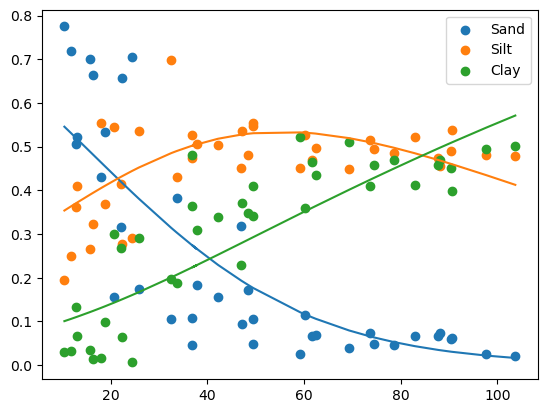

In [69]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_1_ns)
plt.legend()
plt.show()

In [70]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_1_ns))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_1_ns,squared=False))
print('AIC :',2*len(solution_arctic.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1_ns,phi_arctic_1_ns,Y_arctic))

Scores between Y and mu
R2 : 0.5886608462036066
RMSE : 0.10158461863795067
AIC : -141.45619880189471


### With X^2

In [71]:
X_arctic_2 = np.ones((39,3))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2[:,2] = X_arctic[:,0]**2

In [72]:
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

In [73]:
beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
params0_ns = np.concatenate([beta0.flatten(),gamma0])

In [74]:
%%time
solution_arctic_bis=minimize(f_no_spatial, params0_ns, args=(X_arctic_2_bis, Y_arctic, Z_arctic), 
                             jac=fprime_no_spatial)

Wall time: 78.1 ms


In [75]:
beta_arctic_2_ns = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

In [76]:
mu_arctic_2_ns = dirichlet_regression.compute_mu_3(X_arctic_2_bis, beta_arctic_2_ns)

gamma_var_arctic_2_ns = solution_arctic_bis.x[(n_features+2)*n_classes:]
phi_arctic_2_ns = np.exp(np.matmul(Z_arctic,gamma_var_arctic_2_ns))

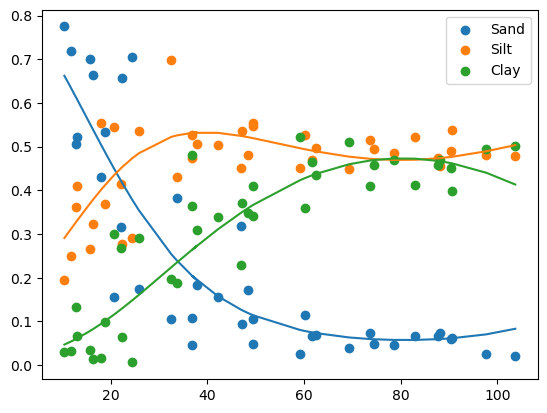

In [77]:
plt.scatter(X_arctic,Y_arctic[:,0],label='Sand')
plt.scatter(X_arctic,Y_arctic[:,1],label='Silt')
plt.scatter(X_arctic,Y_arctic[:,2],label='Clay')
plt.plot(X_arctic, mu_arctic_2_ns)
plt.legend()
plt.show()

In [78]:
print('Scores between Y and mu')
print('R2 :',r2_score(Y_arctic,mu_arctic_2_ns))
print('RMSE :',mean_squared_error(Y_arctic,mu_arctic_2_ns,squared=False))
print('AIC :',2*len(solution_arctic.x) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_ns,phi_arctic_2_ns,Y_arctic))

Scores between Y and mu
R2 : 0.6783095956903394
RMSE : 0.08822009362586831
AIC : -168.56078606846407


In [79]:
print('AIC :',2*(len(solution_arctic.x)-3) - 2*dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_ns,phi_arctic_2_ns,Y_arctic))

AIC : -174.56078606846407


# Table of results

In [81]:
from prettytable import PrettyTable

In [82]:
columns_names = ['MODEL','$R^2$','RMSE','AIC']
pt = PrettyTable(columns_names)
pt.title = 'ARCTIC LAKE RESULTS'
pt.add_row(['NO_SPATIAL_1', 0.5887, 0.1016, -141.5-6])
pt.add_row(['SPATIAL_CONTIGUITY_1', 0.6324, 0.0951, -149.6-6])
pt.add_row(['SPATIAL_DISTANCE_1', 0.6191, 0.0965, -151.6-6])
pt.add_row(['NO_SPATIAL_2', 0.6783, 0.0882, -168.6-6])
pt.add_row(['SPATIAL_CONTIGUITY_2', 0.6863, 0.0866, -165.6-6])
pt.add_row(['SPATIAL_DISTANCE_2', 0.7069, 0.0822, -169.6-6])


print(pt)

+-------------------------------------------------+
|               ARCTIC LAKE RESULTS               |
+----------------------+--------+--------+--------+
|        MODEL         | $R^2$  |  RMSE  |  AIC   |
+----------------------+--------+--------+--------+
|     NO_SPATIAL_1     | 0.5887 | 0.1016 | -147.5 |
| SPATIAL_CONTIGUITY_1 | 0.6324 | 0.0951 | -155.6 |
|  SPATIAL_DISTANCE_1  | 0.6191 | 0.0965 | -157.6 |
|     NO_SPATIAL_2     | 0.6783 | 0.0882 | -174.6 |
| SPATIAL_CONTIGUITY_2 | 0.6863 | 0.0866 | -171.6 |
|  SPATIAL_DISTANCE_2  | 0.7069 | 0.0822 | -175.6 |
+----------------------+--------+--------+--------+


# Curves order 1

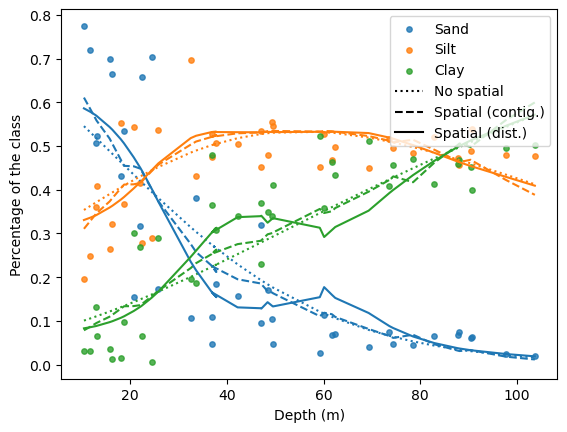

In [166]:
sand = plt.scatter(X_arctic,Y_arctic[:,0],label='Sand',s=15,alpha=.8)
silt = plt.scatter(X_arctic,Y_arctic[:,1],label='Silt',s=15,alpha=.8)
clay = plt.scatter(X_arctic,Y_arctic[:,2],label='Clay',s=15,alpha=.8)
plt.plot(X_arctic, mu_arctic_1_ns, ':')
plt.plot(X_arctic, mu_arctic_1[:,0], '--', c='tab:blue')
plt.plot(X_arctic, mu_arctic_1[:,1], '--', c='tab:orange')
plt.plot(X_arctic, mu_arctic_1[:,2], '--', c='tab:green')
plt.plot(X_arctic, mu_arctic_1_dist[:,0], '-', c='tab:blue')
plt.plot(X_arctic, mu_arctic_1_dist[:,1], '-', c='tab:orange')
plt.plot(X_arctic, mu_arctic_1_dist[:,2], '-', c='tab:green')

dotted_line = plt.Line2D([],[],linestyle=':', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
line = plt.Line2D([],[],linestyle='-', color='black')
plt.legend([sand, silt, clay, dotted_line, dashed_line, line],
            ['Sand','Silt','Clay','No spatial','Spatial (contig.)','Spatial (dist.)'])
#plt.legend()
plt.xlabel('Depth (m)')
plt.ylabel('Percentage of the class')
plt.show()

# Curves order 2

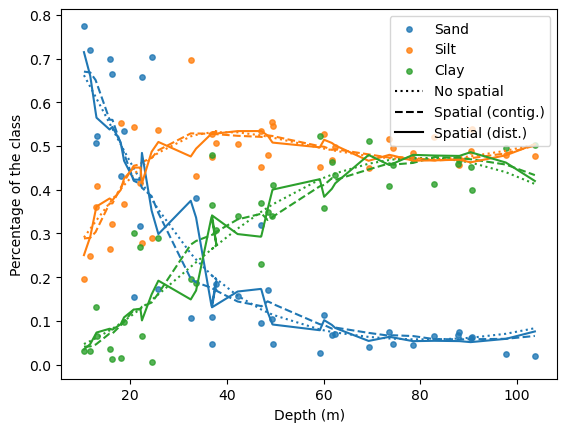

In [167]:
sand = plt.scatter(X_arctic,Y_arctic[:,0],label='Sand',s=15,alpha=.8)
silt = plt.scatter(X_arctic,Y_arctic[:,1],label='Silt',s=15,alpha=.8)
clay = plt.scatter(X_arctic,Y_arctic[:,2],label='Clay',s=15,alpha=.8)
plt.plot(X_arctic, mu_arctic_2_ns, ':')
plt.plot(X_arctic, mu_arctic_2[:,0], '--', c='tab:blue')
plt.plot(X_arctic, mu_arctic_2[:,1], '--', c='tab:orange')
plt.plot(X_arctic, mu_arctic_2[:,2], '--', c='tab:green')
plt.plot(X_arctic, mu_arctic_2_dist[:,0], '-', c='tab:blue')
plt.plot(X_arctic, mu_arctic_2_dist[:,1], '-', c='tab:orange')
plt.plot(X_arctic, mu_arctic_2_dist[:,2], '-', c='tab:green')
dotted_line = plt.Line2D([],[],linestyle=':', color='black')
dashed_line = plt.Line2D([],[],linestyle='--', color='black')
line = plt.Line2D([],[],linestyle='-', color='black')
plt.legend([sand, silt, clay, dotted_line, dashed_line, line],
            ['Sand','Silt','Clay','No spatial','Spatial (contig.)','Spatial (dist.)'])
#plt.legend()
plt.xlabel('Depth (m)')
plt.ylabel('Percentage of the class')
plt.show()

# Leaving one out cross validation

## Order 1

### Without spatial

In [27]:
%%time
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]

params0_ns = np.concatenate([beta0.flatten(),gamma0])

list_r2_ns_1 = []
list_rmse_ns_1 = []
list_ll_ns_1 = []
list_crossentropy_ns_1 = []

for i in range(39):
    X_temp = np.delete(X_arctic_1_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    solution_arctic=minimize(f_no_spatial, params0_ns, args=(X_temp, Y_temp, Z_temp), 
                              jac=fprime_no_spatial)

    beta_arctic_1_ns = solution_arctic.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))

    mu_arctic_1_ns = dirichlet_regression.compute_mu_3(np.array([X_arctic_1_bis[i]]), beta_arctic_1_ns)
    gamma_var_arctic_1_ns = solution_arctic.x[(n_features+1)*n_classes:]
    phi_arctic_1_ns = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_1_ns))
                                                       
    list_r2_ns_1.append(r2_score(Y_arctic[i],mu_arctic_1_ns.flatten()))
    list_rmse_ns_1.append(mean_squared_error(Y_arctic[i],mu_arctic_1_ns.flatten(),squared=False))
    list_ll_ns_1.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1_ns,phi_arctic_1_ns,np.array([Y_arctic[i]])))
    list_crossentropy_ns_1.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_1_ns)))

Wall time: 2.97 s


In [28]:
print('Mean R2 :',np.mean(list_r2_ns_1))
print('Mean RMSE :',np.mean(list_rmse_ns_1))
print('Mean Log-likelihood :',np.mean(list_ll_ns_1))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_ns_1))

Mean R2 : 0.6468960024987289
Mean RMSE : 0.09108036340284113
Mean Log-likelihood : 1.8182130160554613
Mean Cross-entropy : 0.9435967266962815


### With spatial

In [29]:
X_arctic_1 = np.ones((39,2))
X_arctic_1[:,1] = X_arctic[:,0]
X_arctic_1_bis = np.ones((39,2))
X_arctic_1_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)

beta0 = np.array([[0., 0., 0.],[ 0., 0., 0.]])
gamma0 = [0]
rho0 = [0.]

params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

min_bounds_1 = -np.inf*np.ones(len(params0)) 
max_bounds_1 = np.inf*np.ones(len(params0))
min_bounds_1[-1] = -1
max_bounds_1[-1] = 1
bounds = Bounds(min_bounds_1, max_bounds_1)

distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
W_arctic = np.zeros(np.shape(distance_matrix))
W_arctic[distance_matrix < 28] = 1
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [30]:
%%time
list_r2_cont_1 = []
list_rmse_cont_1 = []
list_ll_cont_1 = []
list_crossentropy_cont_1 = []

for i in range(39):  
    X_temp = np.delete(X_arctic_1_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    Wss = np.delete(W_arctic,i,axis=0)
    Wss = np.delete(Wss,i,axis=1)
    Wss = Wss/Wss.sum(axis=1)[:,None]
    
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_temp, Y_temp, Z_temp, Wss), 
                              jac=fprime_spatial, bounds=bounds)
    

    beta_arctic_1_cont = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
    rho_arctic_1_cont = solution_arctic_bis.x[-1]
    mu_arctic_1_cont = dirichlet_regression.compute_mu_spatial_2(X_arctic_1_bis, beta_arctic_1_cont, rho_arctic_1_cont, W_arctic)
    mu_arctic_1_cont = np.array([mu_arctic_1_cont[i]])
    gamma_var_arctic_1_cont = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
    phi_arctic_1_cont = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_1_cont))
                                                       
    list_r2_cont_1.append(r2_score(Y_arctic[i],mu_arctic_1_cont.flatten()))
    list_rmse_cont_1.append(mean_squared_error(Y_arctic[i],mu_arctic_1_cont.flatten(),squared=False))
    list_ll_cont_1.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1_cont,phi_arctic_1_cont,np.array([Y_arctic[i]])))
    list_crossentropy_cont_1.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_1_cont)))

Wall time: 5.81 s


In [31]:
print('Mean R2 :',np.mean(list_r2_cont_1))
print('Mean RMSE :',np.mean(list_rmse_cont_1))
print('Mean Log-likelihood :',np.mean(list_ll_cont_1))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_cont_1))

Mean R2 : 0.6415573377306146
Mean RMSE : 0.08695381310084906
Mean Log-likelihood : 1.9370202064422284
Mean Cross-entropy : 0.9360466612424372


In [32]:
neighbors = NearestNeighbors(n_neighbors=29).fit(X_arctic)
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [33]:
%%time
list_r2_dist_1 = []
list_rmse_dist_1 = []
list_ll_dist_1 = []
list_crossentropy_dist_1 = []

for i in range(39):  
    X_temp = np.delete(X_arctic_1_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    Wss = np.delete(W_arctic,i,axis=0)
    Wss = np.delete(Wss,i,axis=1)
    Wss = Wss/Wss.sum(axis=1)[:,None]
    
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_temp, Y_temp, Z_temp, Wss), 
                              jac=fprime_spatial, bounds=bounds)
    

    beta_arctic_1_dist = solution_arctic_bis.x[:(n_features+1)*n_classes].reshape((n_features+1,n_classes))
    rho_arctic_1_dist = solution_arctic_bis.x[-1]
    mu_arctic_1_dist = dirichlet_regression.compute_mu_spatial_2(X_arctic_1_bis, beta_arctic_1_dist, rho_arctic_1_dist, W_arctic)
    mu_arctic_1_dist = np.array([mu_arctic_1_dist[i]])
    gamma_var_arctic_1_dist = solution_arctic_bis.x[(n_features+1)*n_classes:-1]
    phi_arctic_1_dist = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_1_dist))
                                                       
    list_r2_dist_1.append(r2_score(Y_arctic[i],mu_arctic_1_dist.flatten()))
    list_rmse_dist_1.append(mean_squared_error(Y_arctic[i],mu_arctic_1_dist.flatten(),squared=False))
    list_ll_dist_1.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_1_dist,phi_arctic_1_dist,np.array([Y_arctic[i]])))
    list_crossentropy_dist_1.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_1_dist)))

Wall time: 3.91 s


In [34]:
print('Mean R2 :',np.mean(list_r2_dist_1))
print('Mean RMSE :',np.mean(list_rmse_dist_1))
print('Mean Log-likelihood :',np.mean(list_ll_dist_1))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_dist_1))

Mean R2 : 0.5893325758285615
Mean RMSE : 0.08761418850030797
Mean Log-likelihood : 1.9460485430971626
Mean Cross-entropy : 0.9387214173381191


## Order 2

### Without spatial

In [35]:
%%time
X_arctic_2 = np.ones((39,2))
X_arctic_2[:,1] = X_arctic[:,0]
X_arctic_2_bis = np.ones((39,2))
X_arctic_2_bis = np.ones((39,3))
X_arctic_2_bis[:,1] = X_arctic[:,0]/np.max(X_arctic)
X_arctic_2_bis[:,2] = X_arctic_2_bis[:,1]**2

beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
params0_ns = np.concatenate([beta0.flatten(),gamma0])

list_r2_ns_2 = []
list_rmse_ns_2 = []
list_ll_ns_2 = []
list_crossentropy_ns_2 = []

for i in range(39):
    X_temp = np.delete(X_arctic_2_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    solution_arctic=minimize(f_no_spatial, params0_ns, args=(X_temp, Y_temp, Z_temp), 
                              jac=fprime_no_spatial)

    beta_arctic_2_ns = solution_arctic.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))

    mu_arctic_2_ns = dirichlet_regression.compute_mu_3(np.array([X_arctic_2_bis[i]]), beta_arctic_2_ns)
    gamma_var_arctic_2_ns = solution_arctic.x[(n_features+2)*n_classes:]
    phi_arctic_2_ns = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_2_ns))
                                                       
    list_r2_ns_2.append(r2_score(Y_arctic[i],mu_arctic_2_ns.flatten()))
    list_rmse_ns_2.append(mean_squared_error(Y_arctic[i],mu_arctic_2_ns.flatten(),squared=False))
    list_ll_ns_2.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_ns,phi_arctic_2_ns,np.array([Y_arctic[i]])))
    list_crossentropy_ns_2.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_2_ns)))

Wall time: 2.58 s


In [36]:
print('Mean R2 :',np.mean(list_r2_ns_2))
print('Mean RMSE :',np.mean(list_rmse_ns_2))
print('Mean Log-likelihood :',np.mean(list_ll_ns_2))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_ns_2))

Mean R2 : 0.6368543745850567
Mean RMSE : 0.076535474921698
Mean Log-likelihood : 2.0721305130596313
Mean Cross-entropy : 0.9299284260903892


### With spatial

In [37]:
beta0 = np.array([[ 0., 0., 0.], [0, 0., 0.], [0., 0., 0.]])
gamma0 = [0.]
rho0 = [0.]
params0 = np.concatenate([beta0.flatten(),gamma0,rho0])

min_bounds_2 = -np.inf*np.ones(len(params0)) 
max_bounds_2 = np.inf*np.ones(len(params0))
min_bounds_2[-1] = -1
max_bounds_2[-1] = 1
bounds_2 = Bounds(min_bounds_2, max_bounds_2)

In [38]:
distance_matrix = scipy.spatial.distance_matrix(X_arctic,X_arctic)
W_arctic = np.zeros(np.shape(distance_matrix))
W_arctic[distance_matrix < 26] = 1
# replace the 1 on the diagonal by 0
np.fill_diagonal(W_arctic,0)
# scaling the matrix, so that the sum of each row is 1
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [39]:
%%time
list_r2_cont_2 = []
list_rmse_cont_2 = []
list_ll_cont_2 = []
list_crossentropy_cont_2 = []

for i in range(39):  
    X_temp = np.delete(X_arctic_2_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    Wss = np.delete(W_arctic,i,axis=0)
    Wss = np.delete(Wss,i,axis=1)
    Wss = Wss/Wss.sum(axis=1)[:,None]
    
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_temp, Y_temp, Z_temp, Wss), 
                              jac=fprime_spatial, bounds=bounds_2)
    

    beta_arctic_2_cont = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
    rho_arctic_2_cont = solution_arctic_bis.x[-1]
    mu_arctic_2_cont = dirichlet_regression.compute_mu_spatial_2(X_arctic_2_bis, beta_arctic_2_cont, rho_arctic_2_cont, W_arctic)
    mu_arctic_2_cont = np.array([mu_arctic_2_cont[i]])
    gamma_var_arctic_2_cont = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
    phi_arctic_2_cont = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_2_cont))
                                                       
    list_r2_cont_2.append(r2_score(Y_arctic[i],mu_arctic_2_cont.flatten()))
    list_rmse_cont_2.append(mean_squared_error(Y_arctic[i],mu_arctic_2_cont.flatten(),squared=False))
    list_ll_cont_2.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_cont,phi_arctic_2_cont,np.array([Y_arctic[i]])))
    list_crossentropy_cont_2.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_2_cont)))

Wall time: 9.43 s


In [40]:
print('Mean R2 :',np.mean(list_r2_cont_2))
print('Mean RMSE :',np.mean(list_rmse_cont_2))
print('Mean Log-likelihood :',np.mean(list_ll_cont_2))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_cont_2))

Mean R2 : 0.6378170929003371
Mean RMSE : 0.07559921334907709
Mean Log-likelihood : 2.1378261423636595
Mean Cross-entropy : 0.9280526902897618


In [41]:
neighbors = NearestNeighbors(n_neighbors=5).fit(X_arctic)
W_arctic = neighbors.kneighbors_graph(X_arctic,mode='distance').toarray()
W_arctic = W_arctic/W_arctic.sum(axis=1)[:,None]

In [42]:
%%time
list_r2_dist_2 = []
list_rmse_dist_2 = []
list_ll_dist_2 = []
list_crossentropy_dist_2 = []

for i in range(39):  
    X_temp = np.delete(X_arctic_2_bis,i,axis=0)
    Y_temp = np.delete(Y_arctic,i,axis=0)
    Z_temp = np.delete(Z_arctic,i,axis=0)
    Wss = np.delete(W_arctic,i,axis=0)
    Wss = np.delete(Wss,i,axis=1)
    Wss = Wss/Wss.sum(axis=1)[:,None]
    
    solution_arctic_bis=minimize(f_spatial, params0, args=(X_temp, Y_temp, Z_temp, Wss), 
                              jac=fprime_spatial, bounds=bounds_2)
    

    beta_arctic_2_dist = solution_arctic_bis.x[:(n_features+2)*n_classes].reshape((n_features+2,n_classes))
    rho_arctic_2_dist = solution_arctic_bis.x[-1]
    mu_arctic_2_dist = dirichlet_regression.compute_mu_spatial_2(X_arctic_2_bis, beta_arctic_2_dist, rho_arctic_2_dist, W_arctic)
    mu_arctic_2_dist = np.array([mu_arctic_2_dist[i]])
    gamma_var_arctic_2_dist = solution_arctic_bis.x[(n_features+2)*n_classes:-1]
    phi_arctic_2_dist = np.exp(np.matmul(np.array([Z_arctic[i]]),gamma_var_arctic_2_dist))
                                                       
    list_r2_dist_2.append(r2_score(Y_arctic[i],mu_arctic_2_dist.flatten()))
    list_rmse_dist_2.append(mean_squared_error(Y_arctic[i],mu_arctic_2_dist.flatten(),squared=False))
    list_ll_dist_2.append(dirichlet_regression.dirichlet_loglikelihood(mu_arctic_2_dist,phi_arctic_2_dist,np.array([Y_arctic[i]])))
    list_crossentropy_dist_2.append(np.sum(np.array([Y_arctic[i]])*np.log(mu_arctic_2_dist)))

C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:76: RuntimeWarning: overflow encountered in exp
  exp_MXbeta = np.exp(MXbeta)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:78: RuntimeWarning: invalid value encountered in true_divide
  mu = exp_MXbeta/sum_exp_MXbeta[:,None]
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:122: RuntimeWarning: invalid value encountered in multiply
  sum_mu_digamma_phi_mu = np.sum(mu[i] * digamma_phi_mu)
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:136: RuntimeWarning: invalid value encountered in multiply
  derivative_gamma += Z[i,:]*phi[i]*( digamma(phi[i])+np.sum( mu[i]*(np.log(Y[i]+epsilon)-digamma(phi[i]*mu[i])) ) )
C:\Users\46660461\Documents\GitHub\maupiti\dirichlet_regression.py:285: RuntimeWarning: invalid value encountered in multiply
  sum_i += phi[i]*np.sum( mu[i]*( np.log(Y[i]+epsilon)*(U[i]-sum_omega) - U[i]*(digamma_alpha-np.sum(mu[i]*digamma_alpha)) ) )
C:\User

Wall time: 12.8 s


In [43]:
print('Mean R2 :',np.mean(list_r2_dist_2))
print('Mean RMSE :',np.mean(list_rmse_dist_2))
print('Mean Log-likelihood :',np.mean(list_ll_dist_2))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_dist_2))

Mean R2 : 0.6533979565441214
Mean RMSE : 0.07923980279910585
Mean Log-likelihood : 1.8304669530305273
Mean Cross-entropy : 0.9343904915722435


In [262]:
print('Mean R2 :',np.mean(list_r2_dist_2))
print('Mean RMSE :',np.mean(list_rmse_dist_2))
print('Mean Log-likelihood :',np.mean(list_ll_dist_2))
print('Mean Cross-entropy :',-np.mean(list_crossentropy_dist_2))

Mean R2 : 0.6569017549987071
Mean RMSE : 0.07819064025100718
Mean Log-likelihood : 1.845968267511616
Mean Cross-entropy : 0.9335356063079805


# Table of results

In [84]:
columns_names = ['MODEL','Mean $R^2$','Mean RMSE','Mean LL','Mean Cross-entropy']
pt = PrettyTable(columns_names)
pt.title = 'ARCTIC LAKE RESULTS WITH LOCV'
pt.add_row(['NO SPATIAL 1', np.mean(list_r2_ns_1), np.mean(list_rmse_ns_1), 
            np.mean(list_ll_ns_1),-np.mean(list_crossentropy_ns_1)])
pt.add_row(['SPATIAL contiguity 1', np.mean(list_r2_cont_1), np.mean(list_rmse_cont_1), 
            np.mean(list_ll_cont_1),-np.mean(list_crossentropy_cont_1)])
pt.add_row(['SPATIAL distance 1', np.mean(list_r2_dist_1), np.mean(list_rmse_dist_1), 
            np.mean(list_ll_dist_1),-np.mean(list_crossentropy_dist_1)])
pt.add_row(['NO SPATIAL 2', np.mean(list_r2_ns_2), np.mean(list_rmse_ns_2), 
            np.mean(list_ll_ns_2),-np.mean(list_crossentropy_ns_2)])
pt.add_row(['SPATIAL contiguity 2', np.mean(list_r2_cont_2), np.mean(list_rmse_cont_2), 
            np.mean(list_ll_cont_2),-np.mean(list_crossentropy_cont_2)])
pt.add_row(['SPATIAL distance 2', np.mean(list_r2_dist_2), np.mean(list_rmse_dist_2), 
            np.mean(list_ll_dist_2),-np.mean(list_crossentropy_dist_2)])

print(pt)

+------------------------------------------------------------------------------------------------------------+
|                                       ARCTIC LAKE RESULTS WITH LOCV                                        |
+----------------------+---------------------+---------------------+--------------------+--------------------+
|        MODEL         |      Mean $R^2$     |      Mean RMSE      |      Mean LL       | Mean Cross-entropy |
+----------------------+---------------------+---------------------+--------------------+--------------------+
|     NO SPATIAL 1     |  0.6468960024987288 | 0.09108036340284113 | 1.8182130160554628 | 0.9435967266962815 |
| SPATIAL contiguity 1 |  0.6415573377306143 | 0.08695381310084861 | 1.9370202064422284 | 0.936046661242437  |
|  SPATIAL distance 1  |  0.5893325758285617 | 0.08761418850030792 | 1.9460485430971626 | 0.938721417338119  |
|     NO SPATIAL 2     |  0.6368543745850562 | 0.07653547492169802 | 2.0721305130596326 | 0.9299284260903892 |
|

In [56]:
columns_names = ['MODEL','Mean Cross-entropy','Mean AIC','Mean RMSE','Mean $R^2$']
pt = PrettyTable(columns_names)
pt.title = 'ARCTIC LAKE RESULTS WITH LOOCV'

pt.add_row(['NO SPATIAL 1', 
                str(np.round(-np.mean(list_crossentropy_ns_1),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_1),3)) +')',
               str(np.round(np.mean(2*7-2*np.array(list_ll_ns_1)),1))+' ('+ str(np.round(2*np.std(list_ll_ns_1),3)) +')',
               str(np.round(np.mean(list_rmse_ns_1),3))+' ('+ str(np.round(np.std(list_rmse_ns_1),3)) +')',
               str(np.round(np.mean(list_r2_ns_1),3))+' ('+ str(np.round(np.std(list_r2_ns_1),3)) +')'])

pt.add_row(['SPATIAL contiguity 1', 
                str(np.round(-np.mean(list_crossentropy_cont_1),3))+' ('+ str(np.round(np.std(list_crossentropy_cont_1),3)) +')',
               str(np.round(np.mean(2*8-2*np.array(list_ll_cont_1)),1))+' ('+ str(np.round(2*np.std(list_ll_cont_1),3)) +')',
               str(np.round(np.mean(list_rmse_cont_1),3))+' ('+ str(np.round(np.std(list_rmse_cont_1),3)) +')',
               str(np.round(np.mean(list_r2_cont_1),3))+' ('+ str(np.round(np.std(list_r2_cont_1),3)) +')'])

pt.add_row(['SPATIAL distance 1', 
                str(np.round(-np.mean(list_crossentropy_dist_1),3))+' ('+ str(np.round(np.std(list_crossentropy_dist_1),3)) +')',
               str(np.round(np.mean(2*8-2*np.array(list_ll_dist_1)),1))+' ('+ str(np.round(2*np.std(list_ll_dist_1),3)) +')',
               str(np.round(np.mean(list_rmse_dist_1),3))+' ('+ str(np.round(np.std(list_rmse_dist_1),3)) +')',
               str(np.round(np.mean(list_r2_dist_1),3))+' ('+ str(np.round(np.std(list_r2_dist_1),3)) +')'])

pt.add_row(['NO SPATIAL 2', 
                str(np.round(-np.mean(list_crossentropy_ns_2),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_2),3)) +')',
               str(np.round(np.mean(2*7-2*np.array(list_ll_ns_2)),1))+' ('+ str(np.round(2*np.std(list_ll_ns_2),3)) +')',
               str(np.round(np.mean(list_rmse_ns_2),3))+' ('+ str(np.round(np.std(list_rmse_ns_2),3)) +')',
               str(np.round(np.mean(list_r2_ns_2),3))+' ('+ str(np.round(np.std(list_r2_ns_2),3)) +')'])

pt.add_row(['SPATIAL contiguity 2', 
                str(np.round(-np.mean(list_crossentropy_cont_2),3))+' ('+ str(np.round(np.std(list_crossentropy_cont_2),3)) +')',
               str(np.round(np.mean(2*8-2*np.array(list_ll_cont_2)),1))+' ('+ str(np.round(2*np.std(list_ll_cont_2),3)) +')',
               str(np.round(np.mean(list_rmse_cont_2),3))+' ('+ str(np.round(np.std(list_rmse_cont_2),3)) +')',
               str(np.round(np.mean(list_r2_cont_2),3))+' ('+ str(np.round(np.std(list_r2_cont_2),3)) +')'])

pt.add_row(['SPATIAL distance 2', 
                str(np.round(-np.mean(list_crossentropy_dist_2),3))+' ('+ str(np.round(np.std(list_crossentropy_dist_2),3)) +')',
               str(np.round(np.mean(2*8-2*np.array(list_ll_dist_2)),1))+' ('+ str(np.round(2*np.std(list_ll_dist_2),3)) +')',
               str(np.round(np.mean(list_rmse_dist_2),3))+' ('+ str(np.round(np.std(list_rmse_dist_2),3)) +')',
               str(np.round(np.mean(list_r2_dist_2),3))+' ('+ str(np.round(np.std(list_r2_dist_2),3)) +')'])

print(pt)

+------------------------------------------------------------------------------------------+
|                              ARCTIC LAKE RESULTS WITH LOOCV                              |
+----------------------+--------------------+--------------+---------------+---------------+
|        MODEL         | Mean Cross-entropy |   Mean AIC   |   Mean RMSE   |   Mean $R^2$  |
+----------------------+--------------------+--------------+---------------+---------------+
|     NO SPATIAL 1     |   0.944 (0.104)    | 10.4 (2.535) | 0.091 (0.061) | 0.647 (0.489) |
| SPATIAL contiguity 1 |   0.936 (0.109)    | 12.1 (2.821) | 0.087 (0.055) | 0.642 (0.609) |
|  SPATIAL distance 1  |   0.939 (0.116)    | 12.1 (2.929) | 0.088 (0.058) | 0.589 (0.728) |
|     NO SPATIAL 2     |    0.93 (0.123)    |  9.9 (3.91)  | 0.077 (0.059) | 0.637 (0.683) |
| SPATIAL contiguity 2 |   0.928 (0.123)    | 11.7 (3.899) | 0.076 (0.058) | 0.638 (0.668) |
|  SPATIAL distance 2  |   0.934 (0.121)    | 12.3 (5.717) | 0.079 (0.

In [69]:
np.mean(list_ll_cont_2)

2.1378261423636595

In [70]:
np.mean(list_ll_ns_2)

2.0721305130596313

In [61]:
np.mean(2*8-2*np.array(list_ll_cont_2))

11.72434771527268

In [60]:
np.sum(2*8-2*np.array(list_ll_cont_2))

457.24956089563454

In [62]:
np.mean(2*8-2*np.array(list_ll_ns_2))

11.855738973880738

In [63]:
np.sum(2*8-2*np.array(list_ll_ns_2))

462.3738199813488

In [64]:
-np.sum(list_ll_cont_2)

-83.37521955218273

In [108]:
columns_names = ['MODEL','Mean Cross-entropy','Mean AIC','Mean RMSE','Mean $R^2$']
pt = PrettyTable(columns_names)
pt.title = 'ARCTIC LAKE RESULTS WITH LOOCV'

pt.add_row(['NO SPATIAL 1', 
                str(np.round(-np.mean(list_crossentropy_ns_1),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_1),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_1),1))+' ('+ str(np.round(2*np.std(list_ll_ns_1),3)) +')',
               str(np.round(np.mean(list_rmse_ns_1),3))+' ('+ str(np.round(np.std(list_rmse_ns_1),3)) +')',
               str(np.round(np.mean(list_r2_ns_1),3))+' ('+ str(np.round(np.std(list_r2_ns_1),3)) +')'])

pt.add_row(['SPATIAL contiguity 1', 
                str(np.round(-np.mean(list_crossentropy_cont_1),3))+' ('+ str(np.round(np.std(list_crossentropy_cont_1),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_cont_1),1))+' ('+ str(np.round(2*np.std(list_ll_cont_1),3)) +')',
               str(np.round(np.mean(list_rmse_cont_1),3))+' ('+ str(np.round(np.std(list_rmse_cont_1),3)) +')',
               str(np.round(np.mean(list_r2_cont_1),3))+' ('+ str(np.round(np.std(list_r2_cont_1),3)) +')'])

pt.add_row(['SPATIAL distance 1', 
                str(np.round(-np.mean(list_crossentropy_dist_1),3))+' ('+ str(np.round(np.std(list_crossentropy_dist_1),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_dist_1),1))+' ('+ str(np.round(2*np.std(list_ll_dist_1),3)) +')',
               str(np.round(np.mean(list_rmse_dist_1),3))+' ('+ str(np.round(np.std(list_rmse_dist_1),3)) +')',
               str(np.round(np.mean(list_r2_dist_1),3))+' ('+ str(np.round(np.std(list_r2_dist_1),3)) +')'])

pt.add_row(['NO SPATIAL 2', 
                str(np.round(-np.mean(list_crossentropy_ns_2),3))+' ('+ str(np.round(np.std(list_crossentropy_ns_2),3)) +')',
               str(2*7-2*np.round(np.mean(list_ll_ns_2),1))+' ('+ str(np.round(2*np.std(list_ll_ns_2),3)) +')',
               str(np.round(np.mean(list_rmse_ns_2),3))+' ('+ str(np.round(np.std(list_rmse_ns_2),3)) +')',
               str(np.round(np.mean(list_r2_ns_2),3))+' ('+ str(np.round(np.std(list_r2_ns_2),3)) +')'])

pt.add_row(['SPATIAL contiguity 2', 
                str(np.round(-np.mean(list_crossentropy_cont_2),3))+' ('+ str(np.round(np.std(list_crossentropy_cont_2),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_cont_2),1))+' ('+ str(np.round(2*np.std(list_ll_cont_2),3)) +')',
               str(np.round(np.mean(list_rmse_cont_2),3))+' ('+ str(np.round(np.std(list_rmse_cont_2),3)) +')',
               str(np.round(np.mean(list_r2_cont_2),3))+' ('+ str(np.round(np.std(list_r2_cont_2),3)) +')'])

pt.add_row(['SPATIAL distance 2', 
                str(np.round(-np.mean(list_crossentropy_dist_2),3))+' ('+ str(np.round(np.std(list_crossentropy_dist_2),3)) +')',
               str(2*8-2*np.round(np.mean(list_ll_dist_2),1))+' ('+ str(np.round(2*np.std(list_ll_dist_2),3)) +')',
               str(np.round(np.mean(list_rmse_dist_2),3))+' ('+ str(np.round(np.std(list_rmse_dist_2),3)) +')',
               str(np.round(np.mean(list_r2_dist_2),3))+' ('+ str(np.round(np.std(list_r2_dist_2),3)) +')'])

print(pt)

+-------------------------------------------------------------------------------------------+
|                               ARCTIC LAKE RESULTS WITH LOOCV                              |
+----------------------+--------------------+---------------+---------------+---------------+
|        MODEL         | Mean Cross-entropy |    Mean AIC   |   Mean RMSE   |   Mean $R^2$  |
+----------------------+--------------------+---------------+---------------+---------------+
|     NO SPATIAL 1     |   0.944 (0.104)    |  10.4 (2.535) | 0.091 (0.061) | 0.647 (0.489) |
| SPATIAL contiguity 1 |   0.936 (0.109)    |  12.2 (2.821) | 0.087 (0.055) | 0.642 (0.609) |
|  SPATIAL distance 1  |   0.939 (0.116)    |  12.2 (2.929) | 0.088 (0.058) | 0.589 (0.728) |
|     NO SPATIAL 2     |    0.93 (0.123)    |   9.8 (3.91)  | 0.077 (0.059) | 0.637 (0.683) |
| SPATIAL contiguity 2 |   0.928 (0.123)    |  11.8 (3.899) | 0.076 (0.058) | 0.638 (0.668) |
|  SPATIAL distance 2  |    1.06 (0.857)    | 14.6 (18.531) 

In [95]:
print("Crossentropy:")
print("Order 1, cont :",ttest_ind(list_crossentropy_ns_1,list_crossentropy_cont_1))
print("Order 1, dist :",ttest_ind(list_crossentropy_ns_1,list_crossentropy_dist_1))
print("Order 2, cont :",ttest_ind(list_crossentropy_ns_2,list_crossentropy_cont_2))
print("Order 2, dist :",ttest_ind(list_crossentropy_ns_2,list_crossentropy_dist_2))

Crossentropy:
Order 1, cont : Ttest_indResult(statistic=-0.30937293737590477, pvalue=0.7578844589973897)
Order 1, dist : Ttest_indResult(statistic=-0.19245118950985587, pvalue=0.8479021245241536)
Order 2, cont : Ttest_indResult(statistic=-0.06641663955616138, pvalue=0.9472205317797494)
Order 2, dist : Ttest_indResult(statistic=0.9263521942339799, pvalue=0.3571953581960722)


In [98]:
print("AIC:")
print("Order 1, cont :",ttest_ind(2*7-2*np.array(list_ll_ns_1),2*8-2*np.array(list_ll_cont_1)))
print("Order 1, dist :",ttest_ind(2*7-2*np.array(list_ll_ns_1),2*8-2*np.array(list_ll_dist_1)))
print("Order 2, cont :",ttest_ind(2*7-2*np.array(list_ll_ns_2),2*8-2*np.array(list_ll_cont_2)))
print("Order 2, dist :",ttest_ind(2*7-2*np.array(list_ll_ns_2),2*8-2*np.array(list_ll_dist_2)))

AIC:
Order 1, cont : Ttest_indResult(statistic=-2.8647632081719436, pvalue=0.005393262942222414)
Order 1, dist : Ttest_indResult(statistic=-2.7756727081419257, pvalue=0.006931417417528788)
Order 2, cont : Ttest_indResult(statistic=-2.086088385679677, pvalue=0.040326003808009096)
Order 2, dist : Ttest_indResult(statistic=-1.5155556112233697, pvalue=0.13378009658184586)


In [96]:
print("RMSE:")
print("Order 1, cont :",ttest_ind(list_rmse_ns_1,list_rmse_cont_1))
print("Order 1, dist :",ttest_ind(list_rmse_ns_1,list_rmse_dist_1))
print("Order 2, cont :",ttest_ind(list_rmse_ns_2,list_rmse_cont_2))
print("Order 2, dist :",ttest_ind(list_rmse_ns_2,list_rmse_dist_2))

RMSE:
Order 1, cont : Ttest_indResult(statistic=0.31132642545621647, pvalue=0.7564048550883803)
Order 1, dist : Ttest_indResult(statistic=0.25497948115100794, pvalue=0.799427675540575)
Order 2, cont : Ttest_indResult(statistic=0.06988412245649732, pvalue=0.9444694478667954)
Order 2, dist : Ttest_indResult(statistic=-0.7770144414849864, pvalue=0.4395620840590738)


In [97]:
print("r2:")
print("Order 1, cont :",ttest_ind(list_r2_ns_1,list_r2_cont_1))
print("Order 1, dist :",ttest_ind(list_r2_ns_1,list_r2_dist_1))
print("Order 2, cont :",ttest_ind(list_r2_ns_2,list_r2_cont_2))
print("Order 2, dist :",ttest_ind(list_r2_ns_2,list_r2_dist_2))

r2:
Order 1, cont : Ttest_indResult(statistic=0.042127910649332995, pvalue=0.9665072129765935)
Order 1, dist : Ttest_indResult(statistic=0.40469413920470787, pvalue=0.686839117677637)
Order 2, cont : Ttest_indResult(statistic=-0.006210939868189322, pvalue=0.9950606932530647)
Order 2, dist : Ttest_indResult(statistic=0.8043984365612343, pvalue=0.42367604167069206)


In [106]:
2*np.std(list_rmse_cont_2)

0.11541241343549573

In [107]:
np.std(2*8-2*np.array(list_rmse_cont_2))

0.11541241343549562